In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/understanding_cloud_organization/sample_submission.csv
/kaggle/input/understanding_cloud_organization/train.csv
/kaggle/input/understanding_cloud_organization/train_images/397c2fd.jpg
/kaggle/input/understanding_cloud_organization/train_images/1ea27d0.jpg
/kaggle/input/understanding_cloud_organization/train_images/359b9af.jpg
/kaggle/input/understanding_cloud_organization/train_images/f2cac27.jpg
/kaggle/input/understanding_cloud_organization/train_images/811f41c.jpg
/kaggle/input/understanding_cloud_organization/train_images/b7cabc8.jpg
/kaggle/input/understanding_cloud_organization/train_images/6c989fb.jpg
/kaggle/input/understanding_cloud_organization/train_images/6abfdd7.jpg
/kaggle/input/understanding_cloud_organization/train_images/4001f91.jpg
/kaggle/input/understanding_cloud_organization/train_images/990f987.jpg
/kaggle/input/understanding_cloud_organization/train_images/217fe85.jpg
/kaggle/input/understanding_cloud_organization/train_images/46b1c49.jpg
/kaggle/in

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
from tqdm import tqdm_notebook
import cv2
import gc

import albumentations as albu
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, UpSampling2D, Conv2D, Activation
# from keras.layers.convolutional import Conv2D, Conv2DTranspose
# from keras.layers.pooling import MaxPooling2D
# from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
from keras import optimizers

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

2024-06-21 14:18:34.143097: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-21 14:18:34.143210: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-21 14:18:34.256222: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
path = '../input/understanding_cloud_organization/'

In [4]:
tr = pd.read_csv(path + 'train.csv')
print(len(tr))
tr.head()

22184


,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


In [5]:
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

def mask2rle(img):
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [6]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [7]:
img_size = 256
input_shape = (img_size, img_size, 3)
n_classes = 4 

In [8]:
img_names_all = tr['Image_Label'].apply(lambda x: x.split('_')[0]).unique()
len(img_names_all)

5546

In [9]:
new_ep = False
def keras_generator(batch_size):  
    
    global new_ep,img_names_all
    img_names =  img_names_all.copy()
    while True:   
        
        x_batch = []
        y_batch = []        
        for _ in range(batch_size):                         
            if new_ep == True:
#                 global img_names
                img_names =  img_names_all.copy()
                new_ep = False
            
             
            
            fn = img_names[random.randint(0, len(img_names)-1)]

            img = cv2.imread(path + 'train_images/'+ fn)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)                       
            masks = []
            for rle in tr[tr['Image_Label'].apply(lambda x: x.split('_')[0]) == fn]['EncodedPixels']:                
                if pd.isnull(rle):
                    mask = np.zeros((img_size, img_size))
                else:
                    mask = rle2mask(rle, img.shape)
                    mask = cv2.resize(mask, (img_size, img_size))
                masks.append(mask)                                        
            img = cv2.resize(img, (img_size, img_size))            
            x_batch += [img]
            y_batch += [masks] 

            img_names = img_names[img_names != fn]   
        
        x_batch = np.array(x_batch)
        y_batch = np.transpose(np.array(y_batch), (0, 2, 3, 1))        

        yield x_batch, y_batch

In [10]:
! pip install segmentation-models
!pip install --upgrade segmentation-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.5 MB/s eta 0:00:00


In [11]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)

model = sm.Unet(
    backbone_name=BACKBONE,
    input_shape=input_shape,
    classes=n_classes,
    activation='sigmoid'
)

model.compile(optimizer=Adam(learning_rate=9e-3), loss=bce_dice_loss)

Segmentation Models: using `tf.keras` framework.
94592056/94592056 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [12]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Flatten
from tensorflow.keras import optimizers
import segmentation_models as sm

In [13]:
class EpochBegin(keras.callbacks.Callback):
    def on_epoch_begin (self, epoch, logs={}):
        global new_ep
        new_ep = True
Epoch_Begin_Clb = EpochBegin()

In [14]:
%%time
batch_size = 16
model.fit(keras_generator(batch_size),
              steps_per_epoch=200,                    
              epochs=5,                    
              verbose=1,
              callbacks=[Epoch_Begin_Clb]
              )

Epoch 1/5


I0000 00:00:1718979670.557791      83 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 ━━━━━━━━━━━━━━━━━━━━ 345s 1s/step - loss: 1.1224
Epoch 2/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - loss: 0.9634
Epoch 3/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - loss: 0.9443
Epoch 4/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - loss: 0.9180
Epoch 5/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - loss: 0.8915
CPU times: user 23min 55s, sys: 1min 20s, total: 25min 16s
Wall time: 19min 53s


In [15]:
gc.collect()

11151

In [16]:
%%time

test_img = []
testfiles=os.listdir(path + 'test_images/')
for fn in tqdm_notebook(testfiles):     
        img = cv2.imread( path + 'test_images/'+fn )
        img = cv2.resize(img,(img_size,img_size))       
        test_img.append(img)
len(test_img)

  0%|          | 0/3698 [00:00<?, ?it/s]

CPU times: user 1min 5s, sys: 2.28 s, total: 1min 7s
Wall time: 1min 54s


3698

In [17]:
%%time
predict = model.predict(np.asarray(test_img))

116/116 ━━━━━━━━━━━━━━━━━━━━ 86s 390ms/step
CPU times: user 1min 12s, sys: 4.1 s, total: 1min 17s
Wall time: 1min 32s


In [18]:
%%time
pred_rle = []
for img in predict:      
    img = cv2.resize(img, (525, 350))
    tmp = np.copy(img)
    tmp[tmp<np.mean(img)] = 0
    tmp[tmp>0] = 1
    for i in range(tmp.shape[-1]):
        pred_rle.append(mask2rle(tmp[:,:,i]))
len(pred_rle)

CPU times: user 43.9 s, sys: 11.3 s, total: 55.2 s
Wall time: 34.1 s


14792

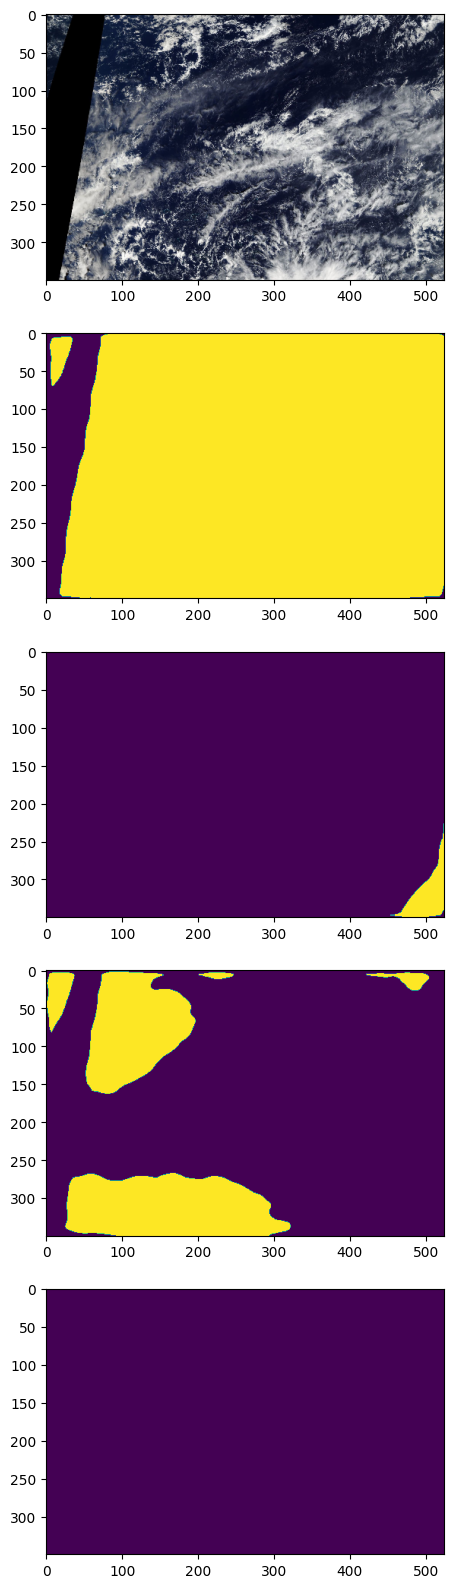

In [19]:
fig, axs = plt.subplots(5, figsize=(20, 20))
axs[0].imshow(cv2.resize(plt.imread(path + 'test_images/' + testfiles[0]),(525, 350)))
for i in range(4):
    axs[i+1].imshow(rle2mask(pred_rle[i], img.shape))

In [20]:
sub = pd.read_csv( path + 'sample_submission.csv', converters={'EncodedPixels': lambda e: ' '} )
sub['EncodedPixels'] = pred_rle
sub.head()

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,1765 8 2112 19 2139 23 2459 61 2808 63 3158 63...
1,002f507.jpg_Flower,158897 1 159247 1 159597 1 159947 1 160297 1 1...
2,002f507.jpg_Gravel,366 3 390 10 712 12 735 22 1059 53 1405 70 175...
3,002f507.jpg_Sugar,
4,0035ae9.jpg_Fish,1451 7 1773 44 1886 17 1905 19 2120 53 2217 60...


In [21]:
sub.to_csv('submission.csv', index=False)